# EC meter saturated saline calibration notebook
This notebook implements the workflow described in `.prompts/EC_meter_sat_saline_calculator.md` for calibrating an EC probe via saturated-saline titration.

## Notebook roadmap
1. Configure experiment parameters and load the saturated-saline drop data.
2. Normalize conductivity values to 25°C and compute the theoretical EC of each mixture step.
3. Fit calibration models that map the probe's raw output to true EC, handling outliers and optional drop-volume sensitivity.
4. Visualize the calibration behaviour and residuals.
5. Export machine-readable artifacts (JSON + firmware header snippet).
6. Compare results against the legacy notebook `EC_meter_calibration_calc.ipynb` and summarize limitations.

In [140]:
from __future__ import annotations

import json
from datetime import datetime
from pathlib import Path
from typing import Optional, Sequence

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
    import seaborn as sns  # type: ignore
    sns.set_theme(style="whitegrid")
except ImportError:
    sns = None

from IPython.display import display

pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 50)

NOTEBOOK_DIR = Path().resolve()

def _detect_project_root(start: Path, anchors: Sequence[str] = ("CMakeLists.txt", ".git")) -> Path:
    for candidate in [start, *start.parents]:
        if any((candidate / anchor).exists() for anchor in anchors):
            return candidate
    return start

PROJECT_ROOT = _detect_project_root(NOTEBOOK_DIR)
print(f"Notebook directory: {NOTEBOOK_DIR}")
print(f"Project root: {PROJECT_ROOT}")

Notebook directory: C:\Users\bazdo\Documents\Git_Working_Directory\homeHydro-S001-ESP-Software\notebooks
Project root: C:\Users\bazdo\Documents\Git_Working_Directory\homeHydro-S001-ESP-Software


In [141]:
default_data_path = (PROJECT_ROOT / "data" / "raw_data_ec_calibration.csv").resolve()
params = {
    "data_csv_path": default_data_path,
    "V0_ml": 500.0,
    "E0_uScm": 327.0,
    "E0_temp_C": 25.0,
    "E_sat_uScm": 292000.0,
    "E_sat_temp_C": 25.0,
    "v_drop_ml": 0.05,
    "drop_volume_sweep_ml": None,  # e.g., [0.045, 0.05, 0.055]
    "alpha_per_C": 0.02,
    "T_C": 25.0,
    "tds_factor": 0.5,
    "divider_supply_v": 3.3,
    "divider_r1_ohms": 1000.0,
    "probe_spacing_cm": 1.35,
    "exclude_outliers": True,
    "outlier_z_threshold": 2.5,
    "export_dir": (PROJECT_ROOT / "ec_calibration"),
    "export_basename": "ec_saturated_drop_calibration",
    "notes": [
        "Data collected with saturated NaCl drops into 500 mL tap water.",
        "Target calibration range extends to ~20 mS/cm.",
    ],
}

params["export_dir"] = Path(params["export_dir"])
params["export_dir"].mkdir(parents=True, exist_ok=True)
params["data_csv_path"] = Path(params["data_csv_path"])
params

{'data_csv_path': WindowsPath('C:/Users/bazdo/Documents/Git_Working_Directory/homeHydro-S001-ESP-Software/data/raw_data_ec_calibration.csv'),
 'V0_ml': 500.0,
 'E0_uScm': 327.0,
 'E0_temp_C': 25.0,
 'E_sat_uScm': 292000.0,
 'E_sat_temp_C': 25.0,
 'v_drop_ml': 0.05,
 'drop_volume_sweep_ml': None,
 'alpha_per_C': 0.02,
 'T_C': 25.0,
 'tds_factor': 0.5,
 'divider_supply_v': 3.3,
 'divider_r1_ohms': 1000.0,
 'probe_spacing_cm': 1.35,
 'exclude_outliers': True,
 'outlier_z_threshold': 2.5,
 'export_dir': WindowsPath('C:/Users/bazdo/Documents/Git_Working_Directory/homeHydro-S001-ESP-Software/ec_calibration'),
 'export_basename': 'ec_saturated_drop_calibration',
 'notes': ['Data collected with saturated NaCl drops into 500 mL tap water.',
  'Target calibration range extends to ~20 mS/cm.']}

In [142]:
def _maybe_generate_synthetic_data(path: Path) -> None:
    if path.exists():
        return
    path.parent.mkdir(parents=True, exist_ok=True)
    rng = np.random.default_rng(42)
    drops = np.arange(0, 16, dtype=int)
    slope_true = 2.45
    intercept_true = 0.2
    noise = rng.normal(0, 0.3, size=drops.size)
    raw_voltage = intercept_true + slope_true * drops + noise
    synthetic = pd.DataFrame({"drop": drops, "raw_voltage_V": raw_voltage.round(3)})
    synthetic.to_csv(path, index=False)
    print(f"Synthetic data written to {path}")


_maybe_generate_synthetic_data(params["data_csv_path"])
df = pd.read_csv(params["data_csv_path"])
df.columns = [col.strip() for col in df.columns]

measurement_candidates = [col for col in ("ec_reported_mScm", "raw_voltage_V") if col in df.columns]
if not measurement_candidates:
    raise ValueError("Input CSV must include either 'raw_voltage_V' or 'ec_reported_mScm'.")
measurement_column = measurement_candidates[0]
measurement_mode = "voltage" if measurement_column == "raw_voltage_V" else "ec"
print(f"Using measurement column: {measurement_column} (mode={measurement_mode})")

df["drop"] = pd.to_numeric(df["drop"], errors="coerce")
if df["drop"].isna().any():
    raise ValueError("Drop number column contains non-numeric values.")

df[measurement_column] = pd.to_numeric(df[measurement_column], errors="coerce")
if df[measurement_column].isna().any():
    raise ValueError(f"Measurement column '{measurement_column}' contains non-numeric values.")

df = df.sort_values("drop").reset_index(drop=True)
if df["drop"].duplicated().any():
    print("Warning: duplicate drop numbers detected; results will keep the first occurrence.")

if "temp_C" in df.columns:
    df["temperature_C"] = pd.to_numeric(df["temp_C"], errors="coerce")
else:
    df["temperature_C"] = np.nan

print(f"Loaded {len(df)} rows from {params['data_csv_path']}")

def _compute_liquid_resistance(voltage_series: pd.Series) -> pd.Series:
    supply_v = float(params["divider_supply_v"])
    r1 = float(params["divider_r1_ohms"])
    denom = supply_v - voltage_series
    resistance = pd.Series(np.nan, index=voltage_series.index, dtype=float)
    valid = (voltage_series > 0.0) & (denom > 0.0)
    resistance.loc[valid] = (r1 * voltage_series.loc[valid]) / denom.loc[valid]
    resistance.loc[~valid & (voltage_series >= supply_v)] = np.inf
    return resistance

display(df.head())


Using measurement column: raw_voltage_V (mode=voltage)
Loaded 94 rows from C:\Users\bazdo\Documents\Git_Working_Directory\homeHydro-S001-ESP-Software\data\raw_data_ec_calibration.csv


,drop,raw_voltage_V,Water level (V) TDS Raw (mS/cm),TDS EMA (mS/cm),Water Level Raw (%),Water Level EMA (%),Unnamed: 6,temperature_C
0,1,2.545,2.562,0.578,0.561,95,131.0,NaN
1,2,2.562,2.562,0.546,0.558,226,150.0,NaN
2,3,2.562,2.562,0.550,0.557,226,165.2,NaN
3,4,2.541,2.562,0.563,0.558,56,143.4,NaN
4,5,2.522,2.562,0.734,0.593,165,147.7,NaN


In [143]:
display(df.describe(include='all').transpose())

,count,mean,std,min,25%,50%,75%,max
drop,94.0,47.500000,27.279418,1.000,24.25000,47.5000,70.75000,94.000
raw_voltage_V,94.0,2.176904,0.109510,2.065,2.11000,2.1405,2.19925,2.562
Water level (V) TDS Raw (mS/cm),94.0,2.197138,0.114474,2.088,2.12575,2.1585,2.22700,2.562
TDS EMA (mS/cm),94.0,1.045745,0.146738,0.546,1.00150,1.0875,1.14725,1.295
Water Level Raw (%),94.0,1.019936,0.162481,0.557,0.97425,1.0730,1.13400,1.178
Water Level EMA (%),94.0,129.425532,69.995774,1.000,67.50000,144.0000,183.00000,249.000
Unnamed: 6,94.0,128.285106,27.145419,66.800,107.02500,128.5000,147.77500,184.800
temperature_C,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [144]:
def ensure_array(value, length: int, name: str = "value") -> np.ndarray:
    if np.isscalar(value):
        return np.full(length, float(value), dtype=float)
    array = np.asarray(value, dtype=float)
    if array.size == 1:
        return np.full(length, float(array.item()), dtype=float)
    if array.size != length:
        raise ValueError(f"{name} must have length {length}, received {array.size}.")
    return array


def resolve_temperature_vector(data: pd.DataFrame, fallback) -> tuple[np.ndarray, str]:
    if "temperature_C" in data.columns and data["temperature_C"].notna().all():
        return data["temperature_C"].to_numpy(dtype=float), "data column 'temperature_C'"
    if "temp_C" in data.columns and data["temp_C"].notna().all():
        return data["temp_C"].to_numpy(dtype=float), "data column 'temp_C'"
    temps = ensure_array(fallback, len(data), name="T_C")
    return temps, "params['T_C']"


def normalize_ec_value(ec_uScm, temp_C, alpha_per_C: float) -> np.ndarray:
    ec_values = np.asarray(ec_uScm, dtype=float)
    temps = np.asarray(temp_C, dtype=float)
    if temps.size == 1:
        temps = np.full(ec_values.shape, float(temps.item()))
    return ec_values / (1.0 + alpha_per_C * (temps - 25.0))


def compute_true_ec_uScm(drops: np.ndarray, params_dict: dict, v_drop_override: Optional[float] = None) -> np.ndarray:
    drops = np.asarray(drops, dtype=float)
    V0 = float(params_dict["V0_ml"])
    v_drop = float(v_drop_override if v_drop_override is not None else params_dict["v_drop_ml"])
    E0_25 = float(normalize_ec_value(params_dict["E0_uScm"], params_dict["E0_temp_C"], params_dict["alpha_per_C"]))
    E_sat_25 = float(normalize_ec_value(params_dict["E_sat_uScm"], params_dict["E_sat_temp_C"], params_dict["alpha_per_C"]))
    numerator = E0_25 * V0 + drops * v_drop * E_sat_25
    volumes = V0 + drops * v_drop
    return numerator / volumes


def regression_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    residuals = y_true - y_pred
    mse = float(np.mean(residuals ** 2))
    rmse = float(np.sqrt(mse))
    mae = float(np.mean(np.abs(residuals)))
    ss_tot = float(np.sum((y_true - np.mean(y_true)) ** 2))
    ss_res = float(np.sum(residuals ** 2))
    r2 = float(1.0 - ss_res / ss_tot) if ss_tot > 0 else float("nan")
    return {"rmse": rmse, "mae": mae, "r2": r2}


def fit_linear_model(x: np.ndarray, y: np.ndarray, fit_intercept: bool = True) -> dict:
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if fit_intercept:
        X = np.column_stack([np.ones_like(x), x])
        beta, *_ = np.linalg.lstsq(X, y, rcond=None)
        intercept, slope = beta.tolist()
        y_hat = X @ beta
    else:
        slope = float(np.dot(x, y) / np.dot(x, x))
        intercept = 0.0
        y_hat = slope * x
    metrics = regression_metrics(y, y_hat)
    return {"slope": float(slope), "intercept": float(intercept), "y_hat": y_hat, "metrics": metrics}


def compute_z_scores(values: pd.Series) -> pd.Series:
    std = values.std(ddof=0)
    if std == 0 or np.isnan(std):
        return pd.Series(np.zeros_like(values, dtype=float), index=values.index)
    return (values - values.mean()) / std

In [145]:
temperature_vector, temperature_source = resolve_temperature_vector(df, params["T_C"])
df["temperature_C"] = temperature_vector
print(f"Temperature source: {temperature_source}")

df["volume_ml"] = params["V0_ml"] + df["drop"] * params["v_drop_ml"]
df["EC_true_uScm"] = compute_true_ec_uScm(df["drop"].to_numpy(dtype=float), params)
df["EC_true_mScm"] = df["EC_true_uScm"] / 1000.0
df["EC_true_mScm_at_sample_temp"] = df["EC_true_uScm"] * (1.0 + params["alpha_per_C"] * (df["temperature_C"] - 25.0)) / 1000.0

if params.get("tds_factor") is not None:
    df["TDS_ppm_estimate"] = df["EC_true_uScm"] * float(params["tds_factor"])

if measurement_mode == "ec":
    reported = df[measurement_column].to_numpy(dtype=float)
    df["EC_reported_mScm"] = reported
    df["EC_reported_mScm_25"] = normalize_ec_value(reported * 1000.0, temperature_vector, params["alpha_per_C"]) / 1000.0
else:
    df["raw_voltage_V"] = df[measurement_column]
    df["liquid_resistance_ohms"] = _compute_liquid_resistance(df["raw_voltage_V"])
    resistance_array = df["liquid_resistance_ohms"].to_numpy(dtype=float)
    conductance_array = np.where(
        np.isfinite(resistance_array) & (resistance_array > 0.0),
        1.0 / resistance_array,
        np.nan,
    )
    df["liquid_conductance_S"] = conductance_array
    spacing_cm = float(params.get("probe_spacing_cm", 1.0))
    df["liquid_conductivity_est_mS_cm"] = conductance_array * spacing_cm * 1000.0

if measurement_mode == "voltage":
    display(df[[
        "drop",
        "raw_voltage_V",
        "liquid_resistance_ohms",
        "liquid_conductance_S",
        "liquid_conductivity_est_mS_cm",
        "EC_true_mScm",
    ]].head())
else:
    display(df.head())

Temperature source: params['T_C']


,drop,raw_voltage_V,liquid_resistance_ohms,liquid_conductance_S,liquid_conductivity_est_mS_cm,EC_true_mScm
0,1,2.545,3370.860927,0.000297,0.400491,0.356164
1,2,2.562,3471.544715,0.000288,0.388876,0.385323
2,3,2.562,3471.544715,0.000288,0.388876,0.414476
3,4,2.541,3347.826087,0.000299,0.403247,0.443623
4,5,2.522,3241.645244,0.000308,0.416455,0.472764


In [146]:
calibration_results: dict = {}
fit_summary_rows: list[dict] = []
through_origin_fit = None

if measurement_mode == "voltage":
    x_all = df["raw_voltage_V"].to_numpy(dtype=float)
    y_all = df["EC_true_mScm"].to_numpy(dtype=float)
    fits_full = {
        "with_intercept": fit_linear_model(x_all, y_all, fit_intercept=True),
        "through_origin": fit_linear_model(x_all, y_all, fit_intercept=False),
    }
    for name, fit in fits_full.items():
        fit_summary_rows.append({
            "dataset": "all",
            "model": name,
            "slope_A": fit["slope"],
            "intercept_B": fit["intercept"],
            "rmse_mScm": fit["metrics"]["rmse"],
            "mae_mScm": fit["metrics"]["mae"],
            "r2": fit["metrics"]["r2"],
            "points": int(len(x_all)),
        })
        df[f"pred_{name}_mScm_all"] = fit["y_hat"]

    df["residual_mScm"] = y_all - fits_full["with_intercept"]["y_hat"]
    df["residual_zscore"] = compute_z_scores(df["residual_mScm"])
    df["is_outlier"] = params["exclude_outliers"] & (df["residual_zscore"].abs() > params["outlier_z_threshold"])

    filtered_mask = ~df["is_outlier"] if params["exclude_outliers"] else np.ones(len(df), dtype=bool)
    if filtered_mask.sum() < len(df):
        x_filtered = df.loc[filtered_mask, "raw_voltage_V"].to_numpy(dtype=float)
        y_filtered = df.loc[filtered_mask, "EC_true_mScm"].to_numpy(dtype=float)
        fits_filtered = {
            "with_intercept": fit_linear_model(x_filtered, y_filtered, fit_intercept=True),
            "through_origin": fit_linear_model(x_filtered, y_filtered, fit_intercept=False),
        }
        for name, fit in fits_filtered.items():
            fit_summary_rows.append({
                "dataset": "filtered",
                "model": name,
                "slope_A": fit["slope"],
                "intercept_B": fit["intercept"],
                "rmse_mScm": fit["metrics"]["rmse"],
                "mae_mScm": fit["metrics"]["mae"],
                "r2": fit["metrics"]["r2"],
                "points": int(filtered_mask.sum()),
            })
        print(f"Excluded {len(df) - int(filtered_mask.sum())} point(s) based on z-score threshold {params['outlier_z_threshold']}")
    else:
        fits_filtered = fits_full

    final_fit = fits_filtered["with_intercept"]
    through_origin_fit = fits_filtered["through_origin"]
    df["pred_with_intercept_mScm"] = final_fit["intercept"] + final_fit["slope"] * df["raw_voltage_V"]
    df["pred_through_origin_mScm"] = through_origin_fit["intercept"] + through_origin_fit["slope"] * df["raw_voltage_V"]
    df["final_residual_mScm"] = df["EC_true_mScm"] - df["pred_with_intercept_mScm"]

    excluded_mask = df["is_outlier"] if "is_outlier" in df.columns else pd.Series(False, index=df.index, dtype=bool)
    calibration_results["model"] = {
        "kind": "voltage_linear",
        "slope_A": final_fit["slope"],
        "intercept_B": final_fit["intercept"],
        "metrics": final_fit["metrics"],
        "points": int((~excluded_mask).sum()),
        "excluded_drop_numbers": df.loc[excluded_mask, "drop"].astype(int).tolist(),
    }
elif measurement_mode == "ec":
    df["K_cell"] = df["EC_true_mScm"] / df["EC_reported_mScm_25"]
    final_fit = None
    calibration_results["model"] = {
        "kind": "ec_scaling",
        "K_cell_mean": float(df["K_cell"].mean()),
        "K_cell_std": float(df["K_cell"].std(ddof=1)),
        "points": int(len(df)),
    }

fit_summary = pd.DataFrame(fit_summary_rows) if fit_summary_rows else None
if fit_summary is not None:
    display(fit_summary)
else:
    display(df[["drop", "K_cell"]])

calibration_results

Excluded 1 point(s) based on z-score threshold 2.5


,dataset,model,slope_A,intercept_B,rmse_mScm,mae_mScm,r2,points
0,all,with_intercept,-4.892336,12.353927,0.574999,0.470677,0.462058,94
1,all,through_origin,0.768489,0.000000,0.843674,0.724346,-0.158110,94
2,filtered,with_intercept,-5.676174,14.028963,0.499436,0.435153,0.587650,93
3,filtered,through_origin,0.762718,0.000000,0.841387,0.721131,-0.170303,93


{'model': {'kind': 'voltage_linear',
  'slope_A': -5.676173536613296,
  'intercept_B': 14.028962615612192,
  'metrics': {'rmse': 0.4994355939981784,
   'mae': 0.4351525902164439,
   'r2': 0.5876500362326196},
  'points': 93,
  'excluded_drop_numbers': [90]}}

In [147]:
if measurement_mode == "voltage" and params.get("drop_volume_sweep_ml"):
    sweep_records = []
    for candidate_v in params["drop_volume_sweep_ml"]:
        ec_true_candidate = compute_true_ec_uScm(df["drop"].to_numpy(dtype=float), params, v_drop_override=candidate_v) / 1000.0
        fit_candidate = fit_linear_model(df["raw_voltage_V"].to_numpy(dtype=float), ec_true_candidate, fit_intercept=True)
        sweep_records.append({
            "v_drop_ml": float(candidate_v),
            "slope_A": fit_candidate["slope"],
            "intercept_B": fit_candidate["intercept"],
            "rmse_mScm": fit_candidate["metrics"]["rmse"],
            "r2": fit_candidate["metrics"]["r2"],
        })
    sweep_df = pd.DataFrame(sweep_records).sort_values("v_drop_ml")
    display(sweep_df)
else:
    print("No drop-volume sweep requested (set params['drop_volume_sweep_ml'] to a list to enable).")

No drop-volume sweep requested (set params['drop_volume_sweep_ml'] to a list to enable).


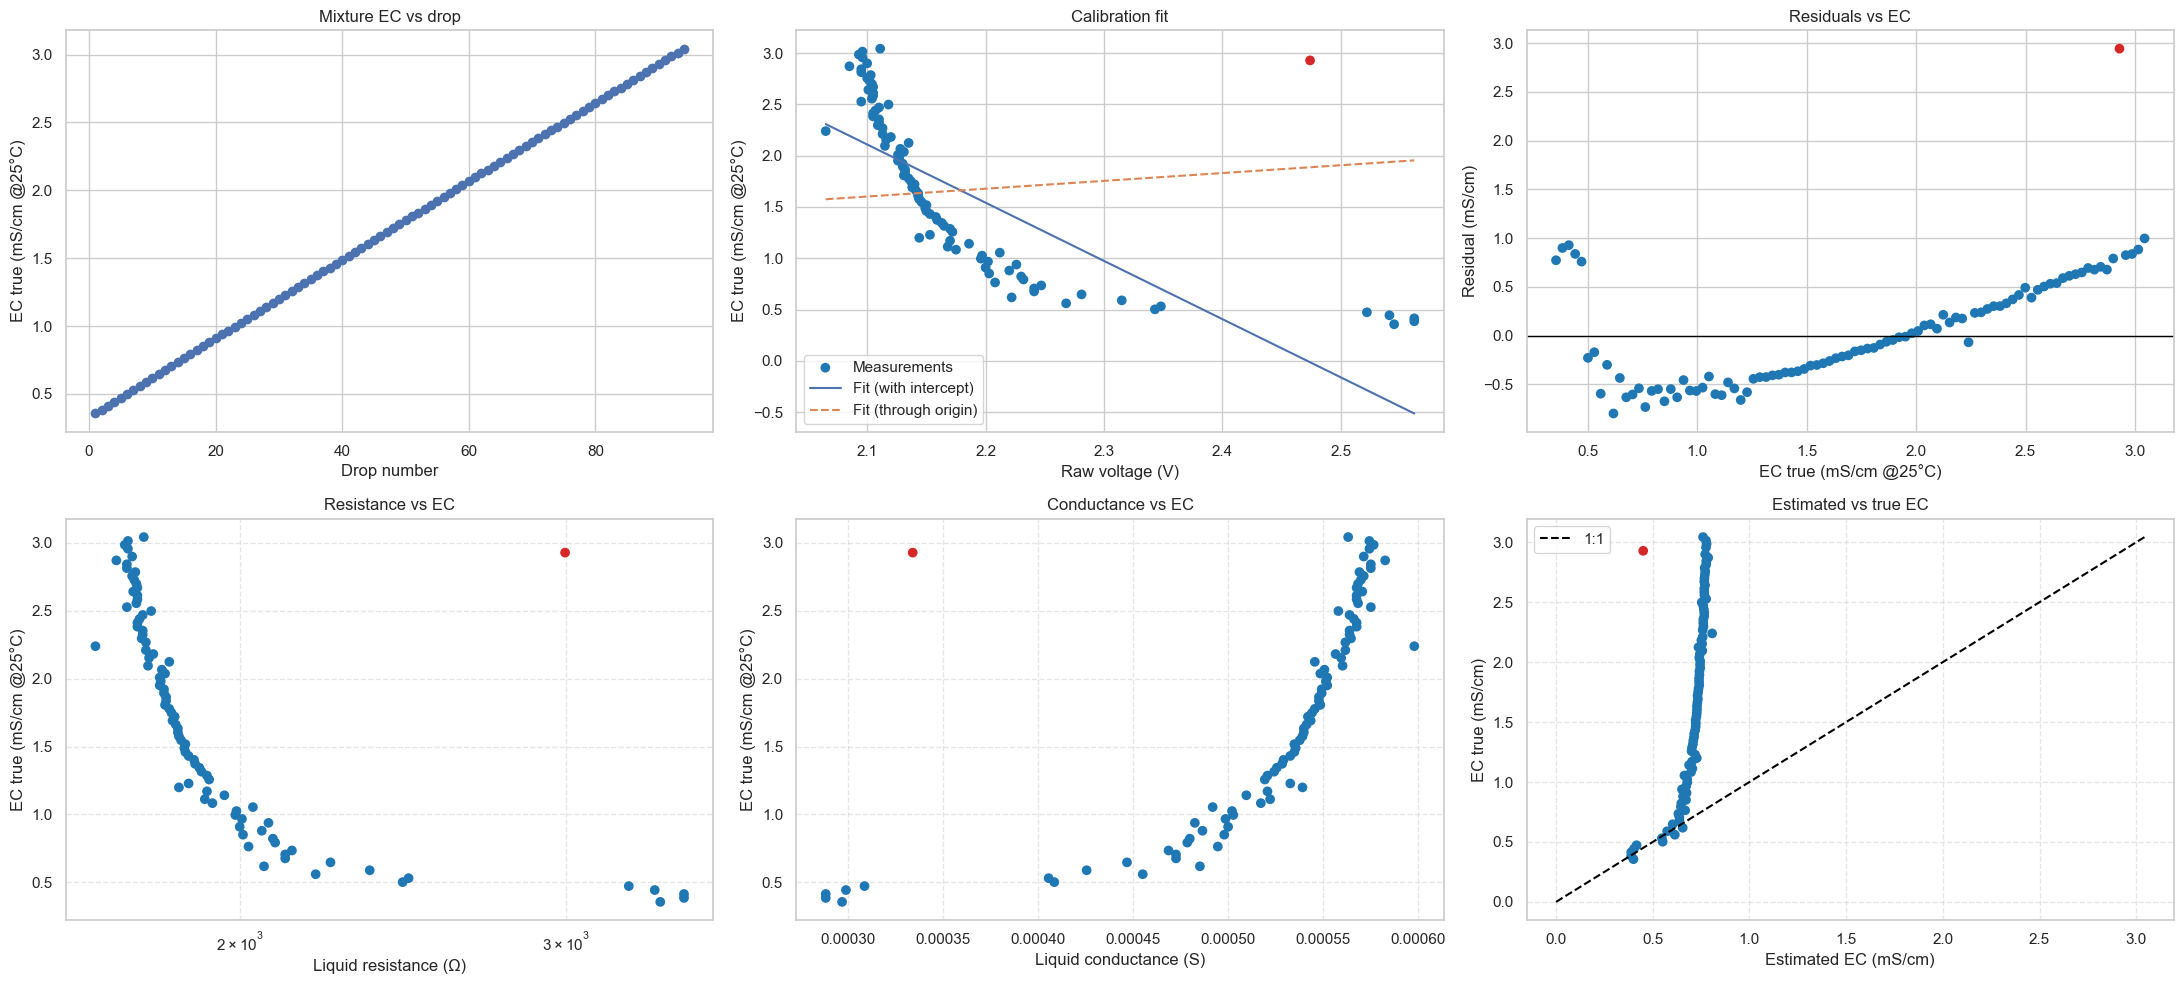

In [148]:
if measurement_mode == "voltage":
    fig, axes = plt.subplots(2, 3, figsize=(22, 10))
else:
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes = np.array(axes).reshape(-1)

axes0 = axes[0]
axes0.plot(df["drop"], df["EC_true_mScm"], marker="o", label="EC_true (25°C)")
axes0.set_xlabel("Drop number")
axes0.set_ylabel("EC true (mS/cm @25°C)")
axes0.set_title("Mixture EC vs drop")
axes0.grid(True)

outlier_mask = df.get("is_outlier")
if outlier_mask is None:
    outlier_mask = pd.Series(False, index=df.index, dtype=bool)
colors = np.where(outlier_mask.to_numpy(dtype=bool), "tab:red", "tab:blue")

if measurement_mode == "voltage":
    axes1 = axes[1]
    axes2 = axes[2]
    axes3 = axes[3]
    axes4 = axes[4]
    axes5 = axes[5]
    axes1.scatter(df["raw_voltage_V"], df["EC_true_mScm"], c=colors, label="Measurements")
    voltage_range = np.linspace(df["raw_voltage_V"].min(), df["raw_voltage_V"].max(), 200)
    axes1.plot(voltage_range, final_fit["intercept"] + final_fit["slope"] * voltage_range, label="Fit (with intercept)")
    axes1.plot(voltage_range, through_origin_fit["slope"] * voltage_range, linestyle="--", label="Fit (through origin)")
    axes1.set_xlabel("Raw voltage (V)")
    axes1.set_ylabel("EC true (mS/cm @25°C)")
    axes1.set_title("Calibration fit")
    axes1.legend()

    axes2.axhline(0.0, color="black", linewidth=1)
    axes2.scatter(df["EC_true_mScm"], df["final_residual_mScm"], c=colors)
    axes2.set_xlabel("EC true (mS/cm @25°C)")
    axes2.set_ylabel("Residual (mS/cm)")
    axes2.set_title("Residuals vs EC")
    axes2.grid(True)

    resistance = df["liquid_resistance_ohms"].to_numpy(dtype=float)
    valid_resistance = np.isfinite(resistance) & (resistance > 0)
    axes3.scatter(resistance[valid_resistance], df["EC_true_mScm"].to_numpy(dtype=float)[valid_resistance], c=colors[valid_resistance])
    axes3.set_xlabel("Liquid resistance (Ω)")
    axes3.set_ylabel("EC true (mS/cm @25°C)")
    axes3.set_title("Resistance vs EC")
    axes3.set_xscale("log")
    axes3.grid(True, which="both", linestyle="--", alpha=0.5)

    conductance = df["liquid_conductance_S"].to_numpy(dtype=float)
    valid_conductance = np.isfinite(conductance) & (conductance > 0)
    axes4.scatter(conductance[valid_conductance], df["EC_true_mScm"].to_numpy(dtype=float)[valid_conductance], c=colors[valid_conductance])
    axes4.set_xlabel("Liquid conductance (S)")
    axes4.set_ylabel("EC true (mS/cm @25°C)")
    axes4.set_title("Conductance vs EC")
    axes4.grid(True, which="both", linestyle="--", alpha=0.5)

    conductivity_est = df["liquid_conductivity_est_mS_cm"].to_numpy(dtype=float)
    valid_conductivity = np.isfinite(conductivity_est)
    axes5.scatter(conductivity_est[valid_conductivity], df["EC_true_mScm"].to_numpy(dtype=float)[valid_conductivity], c=colors[valid_conductivity])
    max_val = np.nanmax(np.concatenate([
        conductivity_est[valid_conductivity],
        df["EC_true_mScm"].to_numpy(dtype=float)[valid_conductivity],
    ]))
    if np.isfinite(max_val) and max_val > 0:
        axes5.plot([0, max_val], [0, max_val], linestyle="--", color="black", label="1:1")
    axes5.set_xlabel("Estimated EC (mS/cm)")
    axes5.set_ylabel("EC true (mS/cm)")
    axes5.set_title("Estimated vs true EC")
    axes5.legend()
    axes5.grid(True, linestyle="--", alpha=0.5)
else:
    axes1 = axes[1]
    axes1.scatter(df["EC_reported_mScm_25"], df["EC_true_mScm"], c=colors)
    max_ec = float(max(df["EC_true_mScm"].max(), df["EC_reported_mScm_25"].max()))
    axes1.plot([0, max_ec], [0, max_ec], linestyle="--", color="black", label="1:1 line")
    axes1.set_xlabel("EC reported (mS/cm @25°C)")
    axes1.set_ylabel("EC true (mS/cm @25°C)")
    axes1.set_title("Reported vs true EC")
    axes1.legend()

    for extra_ax in axes[2:]:
        extra_ax.axis("off")

plt.tight_layout()

In [149]:
summary_rows = []
if measurement_mode == "voltage":
    summary_rows.append({
        "parameter": "slope_A",
        "value": calibration_results["model"]["slope_A"],
        "units": "(mS/cm)/V",
        "notes": "Multiplier applied to raw voltage",
    })
    summary_rows.append({
        "parameter": "intercept_B",
        "value": calibration_results["model"]["intercept_B"],
        "units": "mS/cm",
        "notes": "Offset applied after scaling",
    })
    summary_rows.append({
        "parameter": "RMSE",
        "value": calibration_results["model"]["metrics"]["rmse"],
        "units": "mS/cm",
        "notes": "Root-mean-square error on calibration set",
    })
    summary_rows.append({
        "parameter": "R2",
        "value": calibration_results["model"]["metrics"]["r2"],
        "units": "",
        "notes": "Coefficient of determination",
    })
else:
    summary_rows.append({
        "parameter": "K_cell_mean",
        "value": calibration_results["model"]["K_cell_mean"],
        "units": "dimensionless",
        "notes": "Average cell constant scaling factor",
    })
    summary_rows.append({
        "parameter": "K_cell_std",
        "value": calibration_results["model"]["K_cell_std"],
        "units": "dimensionless",
        "notes": "Standard deviation of K across drops",
    })

summary_df = pd.DataFrame(summary_rows)
display(summary_df)

,parameter,value,units,notes
0,slope_A,-5.676174,(mS/cm)/V,Multiplier applied to raw voltage
1,intercept_B,14.028963,mS/cm,Offset applied after scaling
2,RMSE,0.499436,mS/cm,Root-mean-square error on calibration set
3,R2,0.587650,,Coefficient of determination


In [150]:
export_payload = {
    "generated_at_utc": datetime.utcnow().isoformat() + "Z",
    "data_source": str(params["data_csv_path"].resolve()),
    "measurement_mode": measurement_mode,
    "parameters": {k: (str(v) if isinstance(v, Path) else v) for k, v in params.items()},
    "calibration": calibration_results["model"],
    "tds_factor": params.get("tds_factor"),
    "notes": params.get("notes", []),
}

export_path = params["export_dir"] / f"{params['export_basename']}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
with open(export_path, "w", encoding="utf-8") as fp:
    json.dump(export_payload, fp, indent=2)

latest_export_path = export_path
print(f"Wrote calibration payload to {export_path}")

Wrote calibration payload to C:\Users\bazdo\Documents\Git_Working_Directory\homeHydro-S001-ESP-Software\ec_calibration\ec_saturated_drop_calibration_20250928_135102


In [151]:
if measurement_mode == "voltage":
    header_lines = [
        "// Auto-generated by EC saturated saline calibration notebook",
        "#pragma once",
        "",
        "// EC_true_mScm ≈ EC_SLOPE_A * raw_voltage_V + EC_OFFSET_B",
        f"static constexpr float EC_SLOPE_A = {calibration_results['model']['slope_A']:.6f}f;",
        f"static constexpr float EC_OFFSET_B = {calibration_results['model']['intercept_B']:.6f}f;",
        "",
        "// Calibration statistics",
        f"// RMSE: {calibration_results['model']['metrics']['rmse']:.4f} mS/cm, R^2: {calibration_results['model']['metrics']['r2']:.4f}",
    ]
else:
    header_lines = [
        "// Auto-generated by EC saturated saline calibration notebook",
        "#pragma once",
        "",
        "// EC_true_mScm = EC_reported_mScm * EC_CELL_K",
        f"static constexpr float EC_CELL_K = {calibration_results['model']['K_cell_mean']:.6f}f;",
        "",
        "// Calibration statistics",
        f"// Std(K): {calibration_results['model']['K_cell_std']:.6f}",
    ]

header_snippet = "\n".join(header_lines)
print(header_snippet)

// Auto-generated by EC saturated saline calibration notebook
#pragma once

// EC_true_mScm ≈ EC_SLOPE_A * raw_voltage_V + EC_OFFSET_B
static constexpr float EC_SLOPE_A = -5.676174f;
static constexpr float EC_OFFSET_B = 14.028963f;

// Calibration statistics
// RMSE: 0.4994 mS/cm, R^2: 0.5877


In [152]:
prior_notebook_path = PROJECT_ROOT / "EC_meter_calibration_calc.ipynb"
if prior_notebook_path.exists():
    try:
        import nbformat  # type: ignore
    except ModuleNotFoundError:
        print(
            "Python package 'nbformat' is required to summarize the legacy notebook. "
            "Install it with `pip install nbformat` and re-run this cell if you need the comparison."
        )
    else:
        prior_nb = nbformat.read(prior_notebook_path, as_version=4)
        total_cells = len(prior_nb.cells)
        code_cells = sum(1 for cell in prior_nb.cells if cell.cell_type == "code")
        markdown_cells = sum(1 for cell in prior_nb.cells if cell.cell_type == "markdown")
        uses_sympy = any(
            "sympy" in ("\n".join(cell.source) if isinstance(cell.source, list) else cell.source)
            for cell in prior_nb.cells
            if cell.cell_type == "code"
        )
        print(f"Legacy notebook summary: {total_cells} cells ({code_cells} code / {markdown_cells} markdown)")
        print(f"Contains SymPy setup: {uses_sympy}")
        if markdown_cells:
            first_md_cell = next((cell.source for cell in prior_nb.cells if cell.cell_type == "markdown"), None)
            if first_md_cell:
                first_md = "\n".join(first_md_cell) if isinstance(first_md_cell, list) else first_md_cell
                print("First markdown cell:" + first_md)
else:
    print("Legacy notebook 'EC_meter_calibration_calc.ipynb' not found for comparison.")

Legacy notebook 'EC_meter_calibration_calc.ipynb' not found for comparison.


## Limitations and next steps
- The mixing model assumes linear conductivity scaling with concentration and ignores temperature-driven density changes.
- Drop volume variability can bias the calibration; provide measured values or use the sweep cell to assess sensitivity.
- Temperature compensation uses a constant coefficient (alpha); supply per-solution coefficients if available.
- Re-run the calibration after hardware changes or when the probe is cleaned/replaced.